In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.sparse

from my_models import MyOwnMatrixFactorization

In [3]:
mypath = "/home/mmarzec12/data/"

explicit = pd.read_csv(mypath+"explicit_train.csv")

In [3]:
# unique games and users
unique_users = explicit.user_name.unique()
unique_games = explicit.game_id.unique()

# dictonaries to map users to unique ids and vice vers
us_to_ids = {u:i for i,u in enumerate(unique_users)}
ids_to_us = {i:u for i,u in enumerate(unique_users)}

# dictonaries to map games to unique ids and vice vers
gs_to_ids = {g:i for i,g in enumerate(unique_games)}
ids_to_gs = {i:g for i,g in enumerate(unique_games)}


"""
# creating sparse matrix with data
A = scipy.sparse.lil_matrix((len(unique_users), len(unique_games)))

i = 0
for _,data in joined.iterrows():
    u,g,y = data
    A[us_to_ids[u], gs_to_ids[g]] = y
    
    i+=1
    if i%1_000_000==0:
        print(f"We have added {i} observations.")
"""

# creating sparse matrix with data
row = [us_to_ids[us] for us in explicit.user_name]
col = [gs_to_ids[g] for g in explicit.game_id]
data = explicit.score

A = scipy.sparse.coo_matrix((data, (row, col)), shape=(len(unique_users), len(unique_games)))

<109084x2265 sparse matrix of type '<class 'numpy.float64'>'
	with 5861080 stored elements in COOrdinate format>

In [13]:
mf = MyOwnMatrixFactorization( lambda_=0.02, lr=0.005, n_epochs=20)
mf.fit(A, validation=True)

Preparing validation set...
...validation set created.
Processsing epoch: 1
We went through 1000000 examples in current epoch
We went through 2000000 examples in current epoch
We went through 3000000 examples in current epoch
We went through 4000000 examples in current epoch
Updating weights took 1.85 minutes, we iterated through 4688845 examples.
Training loss: 9364745.81905233, running this epoch took 2.37 minutes
------------------------------------------------------------
Processsing epoch: 2
We went through 1000000 examples in current epoch
We went through 2000000 examples in current epoch
We went through 3000000 examples in current epoch
We went through 4000000 examples in current epoch
Updating weights took 1.85 minutes, we iterated through 4688845 examples.
Training loss: 8080769.619586913, running this epoch took 2.38 minutes
------------------------------------------------------------
Processsing epoch: 3
We went through 1000000 examples in current epoch
We went through 20000

We went through 1000000 examples in current epoch
We went through 2000000 examples in current epoch
We went through 3000000 examples in current epoch
We went through 4000000 examples in current epoch
Updating weights took 1.82 minutes, we iterated through 4688845 examples.
Training loss: 6024638.151634953, running this epoch took 2.34 minutes
------------------------------------------------------------
End of training, the whole process took 48.75 minutes.


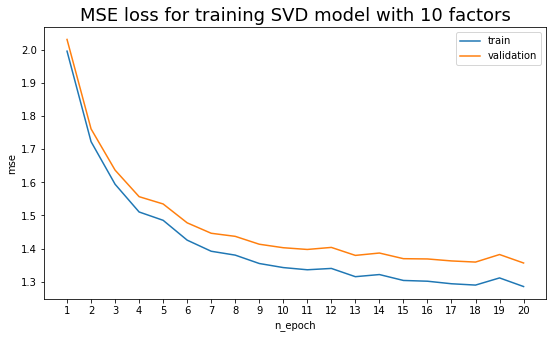

In [14]:
plt.figure(figsize=(9,5))
plt.title(f"MSE loss for training SVD model with {mf.n_factors} factors", fontsize=18)
x_axis = range(1,len(mf.mse_train)+1)
plt.plot(x_axis, mf.mse_train)
plt.plot(x_axis, mf.mse_val)
plt.xticks(x_axis)
plt.ylabel("mse")
plt.xlabel("n_epoch")
plt.legend(["train", "validation"])
plt.show()

In [13]:
k=10
#np.max(np.ones(k), np.log2(np.arange(1,k+1)))
len(1. / np.log2(np.arange(2, k + 2)))

10

In [ ]:
def leave_one_out_NDCG(true, predicted,k):
    """
    Description:
    -----------
    
    function to compute NDCG@k for leave-one-out
    validation strategy (1 item for each user)
    
    Assumptions: the only one item that is present for
    each user has relevane=1 all remaining have relevance=0
    
    
    Parameters:
    ----------
    
    true - list of tuples with (user_id, item_id), these are 
    the items which we want to see at the top of recommendation list
    
    predicted - dict with users and their recommendations
    in form: {user_id:[top_k_recommendation_list]}, where the top_k_list
    contains item_ids
    
    k - to calculate NDCG@k
    
    """

    ndcgs = []
    denoms = 1. / np.log2(np.arange(2, k + 2))
    
    # ideal DCG
    IDCG = denoms[0]
    
    for uid,iid in true:
        pos = 0
        for item_id in predicted[uid]:
            if item_id==iid:
                res.append(denoms[pos] / IDCG)
                break
            else:
                pos += 1
                
        # if item from test set is not in top-k list
        if pos == k-1:
            res.append(0/IDCG)
        
    return np.mean(ndcgs)

In [ ]:
def NDCG_k(X, pred_top_k, k=None):
    """
    X - sparse matrix n_users x n_items
    pred - dictionary with user ids as keys 
    and lists with top k recommendations (item ids) as values
    k - can't be greater than length of top-k items recommendation list
    if k==none, then k is set to length of recommendation list
    """

    if k is None:
        k = len(list(pred_top_k.values())[0])
    
    X = X.tocsr()
    true_all = (-1*np.sort(-X.todense(), axis=1))
    
    res = []
    denoms = {i: max(1, np.log2(i)) for i in range(1, k+1)}

    for user_id in pred_top_k.keys():
        user_ndcg = 0
        true = 0
        user_top_k = pred_top_k[user_id]
        for i in range(k):
            item_id = user_top_k[i]
            user_ndcg += X[user_id, item_id] / denoms[i+1]
            true += true_all[user_id, i] / denoms[i+1]
        res.append(user_ndcg / true)

    return np.mean(res)

In [40]:
import numpy as np
import scipy
import random

from scipy.sparse import coo_matrix, lil_matrix
from time import perf_counter
from tqdm import tqdm

class MF:

    def __init__(self, lr=0.001, lambda_=0.05, n_epochs=10, n_factors=10):
        self.lr = lr
        self.lambda_ = lambda_  # regularization power
        self.n_epochs = n_epochs
        self.n_factors = n_factors

    def split(self, X, val_size=0.2, verbose=False):
        """
        Function for splitting train data for 2 disjoint sets,
        following the rule that we select val_size*(number of user ratings)
        values for each user in validation set.
        """


        X = X.tocsr()
        train = scipy.sparse.lil_matrix(X.shape, dtype=np.float32)
        val = scipy.sparse.lil_matrix(X.shape, dtype=np.float32)

        # if we want to display progress bar:
        if verbose:
            print("Spliting dataset...")
            iterator = tqdm(range(X.shape[0]))
        else:
            iterator = range(X.shape[0])

        # we iterate through each user
        for u in iterator:
            # select "users row"
            x = X[u]
            # get the number of values (ratings) for given user
            n = x.nnz
            # shuffle the ids
            ids = x.indices.copy()
            np.random.shuffle(ids)
            # set train and validation ids
            ids_val = ids[:round(n*val_size)]
            ids_train = ids[round(n*val_size):]

            # append values to train and val matrices
            train[u, ids_train] = x[0,ids_train]
            val[u, ids_val] = x[0,ids_val]

        return train, val


    def MSE(self, X):
        X = X.tocoo()
        """
        Takes coo sparse matrix as input and calculate MSE
        for the given data.
        """
        loss = 0
        for u,i,r in zip(X.row, X.col, X.data):
            loss += (r - (self.mu + self.bu[u] + self.bi[i] + np.dot(self.pu[u,], self.qi[i,])))**2
        return loss / X.nnz


    def update_model_params(self, pu, qi, bu, bi, mu):
        self.pu = pu
        self.qi = qi
        self.bu = bu
        self.bi = bi
        self.mu = mu
    
    def calculate_rating(self, u, i):
        return self.mu + self.bu[u] + self.bi[i] + np.dot(self.pu[u], self.qi[i])
    

    def fit(self, X, verbose=True, validation=False, validation_size=0.2):

        big_start = perf_counter()
        n_users = X.shape[0]
        n_items = X.shape[1]
        self.n_users = n_users
        self.n_items = n_items
        lr = self.lr
        n_factors = self.n_factors
        lambda_ = self.lambda_
        n_epochs = self.n_epochs
        # model parameters
        pu = np.random.normal(size=(n_users, n_factors))
        qi = np.random.normal(size=(n_items, n_factors))
        mu = 0
        bu = np.random.normal(size=n_users)
        bi = np.random.normal(size=n_items)

        # losses
        loss = []
        mse_train = []
        # convert X to coo_matrix and potentialy make a validation set
        if validation:
            mse_val = []
            print("Preparing validation set...")
            train, val = self.split(X, validation_size)
            # we have to  change the format to scipy.sparse.coo_matrix
            #train, val = train.tocoo(), val.tocoo()
            train, val = train.tolil(), val.tolil()
            print("...validation set created.")
        else:
            #train = X.tocoo()
            train = X.tolil()
        
        # create idx list of pairs to iterate randomly
        idx_list = [(u,i) for u,i in zip(train.nonzero()[0], train.nonzero()[1])]
        self.X = X
        for epoch in range(n_epochs):
            if verbose:
                print(f'Processsing epoch: {epoch+1}')
                start = perf_counter()

            #  stochastic gradient descent
            j = 0
            # (for deterministc coo: iterate zip(B.row, B.col, B.data))
            random.shuffle(idx_list)
            for u,i in idx_list:
                r = train[u,i]
                error_ui = r - (mu + bu[u] + bi[i] + np.dot(pu[u], qi[i]))
                
                # update pu
                pu[u,] += lr*(qi[i,]*error_ui - lambda_*pu[u])
                # update qi
                qi[i,] += lr*(pu[u,]*error_ui - lambda_*qi[i])
                
                # update user bias
                bu[u] += lr*(error_ui - lambda_*bu[u])
                
                # update movie bias
                bi[i] += lr*(error_ui - lambda_*bi[i])
                
                # update global bias
                mu += lr*(error_ui)

                j += 1
                if j%1_000_000==0:
                    print(f"We went through {j} examples in current epoch")
            
            if verbose:
                end = perf_counter()
                print(f"Updating weights took {round((end-start)/60,2)} minutes, we iterated through {j} examples.")
            
            # adding obtained parameters to function attributes
            self.update_model_params(pu=pu, qi=qi, bu=bu, bi=bi, mu=mu)
            
            # after full epoch calculate and update loss
            current_mse_train = self.MSE(train)
            mse_train.append(current_mse_train)
            if validation:
                current_mse_val = self.MSE(val)
                mse_val.append(current_mse_val)
            
            total_loss = lambda_* (np.linalg.norm(pu) + np.linalg.norm(qi) + np.linalg.norm(bu) + np.linalg.norm(bi))
            total_loss += current_mse_train * train.nnz
            loss.append(total_loss)

            if verbose:
                end = perf_counter()
                elapsed = end - start
                print(f"Training loss: {total_loss}, running this epoch took {round(elapsed/60, 2)} minutes")
                print("-"*60)
        

        # loss includes regularization term, mse_train does not
        # moreover mse is average and loss is sum
        self.loss = loss
        self.mse_train = mse_train

        if validation:
            self.mse_val = mse_val

        if verbose:
            big_end = perf_counter()
            print(f"End of training, the whole process took {round((big_end - big_start)/60, 2)} minutes.")
        return

    def predict_top_k(self, user_ids, k):
        Xlil = self.X.tolil()
        d = {user_id: None for user_id in user_ids}
        for user_id in user_ids:
            known = np.array(Xlil.rows[user_id])
            ratings = np.array([self.calculate_rating(u=user_id, i=i) for i in range(self.n_items)])
            ratings = ratings[~known]
            sorted_ids_k = np.argsort(-ratings)[:k]
            d[user_id] = sorted_ids_k
        return d

In [ ]:
mf = SVDrec(n_epochs=30, n_factors=50)
mf.fit(A)

Processsing epoch: 1
We went through 1000000 examples in current epoch
We went through 2000000 examples in current epoch
We went through 3000000 examples in current epoch
We went through 4000000 examples in current epoch
We went through 5000000 examples in current epoch
Updating weights took 2.03 minutes, we iterated through 5861080 examples.
Training loss: 14158075.235063925, running this epoch took 2.32 minutes
------------------------------------------------------------
Processsing epoch: 2
We went through 1000000 examples in current epoch
We went through 2000000 examples in current epoch
We went through 3000000 examples in current epoch
We went through 4000000 examples in current epoch
We went through 5000000 examples in current epoch
Updating weights took 2.06 minutes, we iterated through 5861080 examples.
Training loss: 6109589.489452627, running this epoch took 2.35 minutes
------------------------------------------------------------
Processsing epoch: 3
We went through 1000000 

We went through 2000000 examples in current epoch
We went through 3000000 examples in current epoch
We went through 4000000 examples in current epoch
We went through 5000000 examples in current epoch
Updating weights took 2.03 minutes, we iterated through 5861080 examples.
Training loss: 758107.7110963593, running this epoch took 2.32 minutes
------------------------------------------------------------
Processsing epoch: 19
We went through 1000000 examples in current epoch
We went through 2000000 examples in current epoch
We went through 5000000 examples in current epoch
Updating weights took 2.04 minutes, we iterated through 5861080 examples.
Training loss: 710290.8264074068, running this epoch took 2.32 minutes
------------------------------------------------------------
Processsing epoch: 20
We went through 1000000 examples in current epoch
We went through 2000000 examples in current epoch
We went through 3000000 examples in current epoch
We went through 4000000 examples in current 